In [12]:
#### Dependencies

from anytree import Node, NodeMixin, RenderTree
from PIL import Image
from PIL import ImageDraw

import glob
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import timeit


In [13]:
#### Global variables

model = {}
simplified_model = {}
map_8bit_to_3bit = [i // 32 for i in range(256)]


In [14]:
#### Classes

class MyBaseClass(object):
    foo = 4

class TreeNode(MyBaseClass, NodeMixin):
    def __init__(self, subset, purity, glcm_index, glcm_median, dominant_class='', parent=None, children=None):
        super(TreeNode, self).__init__()
        self.subset = subset
        self.purity = purity
        self.glcm_index = glcm_index
        self.glcm_median = glcm_median
        self.dominant_class = dominant_class
        if(not children == None):
            self.children = children
            

In [22]:
#### Functions

def load_img(img_path):
    return Image.open(img_path).convert('L')

def get_img_size(img):
    return img.size

def print_img(img):
    plt.imshow(img, cmap='gray')
    
def get_img_colors(img, sampling_count):
    img_width, img_height = get_img_size(img)
    
    sample_width = int(img_width / sampling_count)
    sample_height = int(img_height / sampling_count)
    
    half_sample_width = int(sample_width/2)
    half_sample_height = int(sample_height/2)

    img_colors = []

    width_constraint = img_width - (2 * sample_width)
    height_constraint = img_height - (2 * sample_height)
   
    row = 0
    for point_x in range(half_sample_width, img_width, sample_width):
        if(row == sampling_count):
            break
        column = 0
        for point_y in range(half_sample_height, img_height, sample_height):
            if(column == sampling_count):
                break
            img_colors.append(img.getpixel((point_x, point_y)))
                
            column += 1
                
        row += 1
            
    return img_colors

def construct_img(img_colors, img_dimension, sampling_count):
    img_new = Image.new('RGB', (img_dimension), (255, 255, 255))
    draw = ImageDraw.Draw(img_new)
    
    img_new_width = img_dimension[0]
    img_new_height = img_dimension[1]

    sample_width = int(img_new_width/sampling_count)
    sample_height = int(img_new_height/sampling_count)
    loop_count = 0

    img_colors_len = len(img_colors)

    for w in range(0, img_new_width, sample_width):
        for h in range(0, img_new_height, sample_height):
            if(loop_count == img_colors_len):
                break
            
            current_color = (img_colors[loop_count], img_colors[loop_count], img_colors[loop_count])
            draw.rectangle((w, h, w+sample_width, h+sample_height), fill=current_color)
            loop_count += 1
    
    return img_new

def get_3bit_colors(img_colors):
    loop_count = 0
    
    for img_color in img_colors:
        img_colors[loop_count] = map_8bit_to_3bit[img_color]
        
        loop_count += 1
        
    return img_colors

def get_img_matrix(img_colors):
    img_matrix = [] 
    loop_count = 0
    
    for row in range(8):
        new_img_matrix_row = []
        for col in range(8):
            new_img_matrix_row.append(img_colors[loop_count])
            
            loop_count += 1
        img_matrix.append(new_img_matrix_row)
        
    return img_matrix

def get_img_features(img, sampling_count, angle, distance):
    img_colors = get_img_colors(img, sampling_count)
    img_3bit_colors = get_3bit_colors(img_colors)
    img_matrix = get_img_matrix(img_3bit_colors)
    
    glcm_matrix = [[0 for j in range(8)] for i in range(8)] 
    non_zero_glcm_indexes = []
    
    total_pair = 0
    loop_count = 0
    row_id = 0
    for row in img_matrix:
        col_id = 0
        for col in row:
            current_color = col
            neighbor_color = 999
            
            try:
                if(angle == 0):
                    neighbor_color = img_matrix[row_id][col_id + distance]
                elif(angle == 45):
                    neighbor_color = img_matrix[row_id - distance][col_id + distance]
                elif(angle == 90):
                    neighbor_color = img_matrix[row_id - distance][col_id]
                elif(angle == 135):
                    neighbor_color = img_matrix[row_id - distance][col_id - distance]
                    
                glcm_matrix[current_color][neighbor_color] += 1
                total_pair += 1
                
                current_index = (row_id, col_id)
                if(not current_index in non_zero_glcm_indexes):
                    non_zero_glcm_indexes.append(current_index)
            except Exception:
                pass            
            
            col_id += 1
            
        row_id += 1
        
    # Contrast
    img_contrast = 0
    
    # Correlation
    avg_row_glcm = 0
    avg_col_glcm = 0
    
    # Energy
    img_energy = 0
    
    # Homogenity
    img_homogenity = 0
    
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] /= total_pair
        
        # calculate image's contrast
        img_contrast += ((non_zero_glcm_row_id - non_zero_glcm_col_id) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
        # calculate image's correlation
        avg_row_glcm += non_zero_glcm_row_id * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        avg_col_glcm += non_zero_glcm_col_id * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
        # calculate image's energy
        img_energy += glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] ** 2
        
        # calculate image's homogenity
        img_homogenity += glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id] / (1 + abs(non_zero_glcm_row_id - non_zero_glcm_col_id))
        
    # Correlation
    sigma_row_glcm = 0
    sigma_col_glcm = 0
        
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        # calculate image's correlation
        sigma_row_glcm += ((non_zero_glcm_row_id - avg_row_glcm) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        sigma_col_glcm += ((non_zero_glcm_col_id - avg_col_glcm) ** 2) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]
        
    # Correlation
    sigma_row_glcm = math.sqrt(sigma_row_glcm)
    sigma_col_glcm = math.sqrt(sigma_col_glcm)
    img_correlation = 0
    
    if(sigma_row_glcm == 0 or sigma_col_glcm == 0):
        sigma_row_glcm = 1
        sigma_col_glcm = 1
    
    for non_zero_glcm_index in non_zero_glcm_indexes:
        non_zero_glcm_row_id = non_zero_glcm_index[0]
        non_zero_glcm_col_id = non_zero_glcm_index[1]
        
        # calculate image's correlation
        img_correlation += ((non_zero_glcm_row_id - avg_row_glcm) * (non_zero_glcm_col_id - avg_col_glcm) * glcm_matrix[non_zero_glcm_row_id][non_zero_glcm_col_id]) / (sigma_row_glcm * sigma_col_glcm)
    
    glcm_values = (img_contrast, img_correlation, img_energy, img_homogenity)
    
    return glcm_values

# Modelling

def initialize_model():
    global model
    global simplified_model
    
    model = {}
    simplified_model = {}
    
def get_class_names(training_folder_path):
    return os.listdir(training_folder_path)

def add_classes_to_model(class_names):
    for class_name in class_names:
        if not class_name in model:
            model[class_name] = []
        if not class_name in simplified_model:
            simplified_model[class_name] = (0, 0, 0, 0)
            
def add_features_to_model(class_name, features):
    if(class_name in model):
        model[class_name].append(features)
        
def get_normalized_model(model):
    normalized_model = []
    
    for class_name in model:
        for glcm_values in model[class_name]:
            new_row = (class_name, glcm_values[0], glcm_values[1], glcm_values[2], glcm_values[3])
            normalized_model.append(new_row)
    
    return normalized_model
    
def get_class_names_in_model():
    class_names = []
    for class_name in model:
        class_names.append(class_name)
        
    return class_names

# Training
        
def train(training_folder_path, img_type, sampling_count, glcm_angle, glcm_distance):
    print('Training...')
    class_names = get_class_names(training_folder_path)
    for class_name in class_names:
        training_img_paths = glob.glob(training_folder_path + class_name + '/' + img_type)

        for training_img_path in training_img_paths:
            #print('Training on ' + training_img_path)
            training_img = load_img(training_img_path)

            training_img_class_name = class_name
            training_img_glcm_features = get_img_features(training_img, sampling_count, glcm_angle, glcm_distance)

            add_features_to_model(training_img_class_name, training_img_glcm_features)
        
        simplified_model[class_name] = tuple(np.median(model[class_name], axis=0))
    print('└── Done')
        
# Classification

def get_subset_purity(subset, minimum_purity=0.8):
    if(len(subset) > 0):
        class_names = get_class_names_in_model()

        #untuk 2 class
        total_class_score = len(subset)
        subset_class_scores = [0, 0]

        class_index = 0
        for class_name in class_names:
            for row in subset:
                if(row[0] == class_name):
                    subset_class_scores[class_index] += 1

            class_index += 1


        purity = 0
        class_index = 0
        for class_name in class_names:
            if(class_index % 2 == 0):
                purity += subset_class_scores[class_index] / total_class_score
            else:
                purity -= subset_class_scores[class_index] / total_class_score

            class_index += 1

        purity = abs(purity)

        dominant_class = ''
        if(purity >= minimum_purity):
            if(subset_class_scores[0] > subset_class_scores[1]):
                dominant_class = class_names[0]
            else:
                dominant_class = class_names[1]

        return (purity, dominant_class)
    else:
        return (0, '')

def get_tree_seed(model, minimum_purity=0.8):
    normalized_model = get_normalized_model(model)
    tree = TreeNode(normalized_model, get_subset_purity(normalized_model, minimum_purity)[0], 0, 0, '')
        
    return tree

def get_decision_tree(decision_tree, minimum_purity=0.8):
    if(decision_tree.purity >= minimum_purity or len(decision_tree.subset) == 0):
        return decision_tree
    else:
        subset = decision_tree.subset

        class_names = get_class_names_in_model()

        future_subset_purities = [[0, 0], [1, 0], [2, 0], [3, 0]]
        glcm_medians   = [0, 0, 0, 0]
        left_subsets   = [[], [], [], []]
        right_subsets  = [[], [], [], []]
        left_purities  = [0, 0, 0, 0]
        right_purities = [0, 0, 0, 0]
        left_dominants  = ['', '', '', '']
        right_dominants  = ['', '', '', '']
        for glcm_index in range(4):
            sorted_subset = sorted(subset, key=lambda x: x[glcm_index + 1])

            glcm_mid_index             = len(sorted_subset)//2
            glcm_medians[glcm_index]   = sorted_subset[glcm_mid_index][glcm_index + 1]

            left_subsets[glcm_index]   = sorted_subset[:glcm_mid_index]
            right_subsets[glcm_index]  = sorted_subset[glcm_mid_index:]

            left_purity_and_dominant = get_subset_purity(left_subsets[glcm_index], minimum_purity)
            right_purity_and_dominant = get_subset_purity(right_subsets[glcm_index], minimum_purity)

            left_purities[glcm_index]  = left_purity_and_dominant[0]
            right_purities[glcm_index] = right_purity_and_dominant[0]

            left_dominants[glcm_index]  = left_purity_and_dominant[1]
            right_dominants[glcm_index] = right_purity_and_dominant[1]

            if(left_purities[glcm_index] >= minimum_purity):
                future_subset_purities[glcm_index][1] += 1
            if(right_purities[glcm_index] >= minimum_purity):
                future_subset_purities[glcm_index][1] += 1
                
        sorted_future_subset_purities = sorted(future_subset_purities, key= lambda x: -x[1])
        glcm_index = sorted_future_subset_purities[0][0]

        left_subset = left_subsets[glcm_index]
        left_purity = left_purities[glcm_index]

        right_subset = right_subsets[glcm_index]
        right_purity = right_purities[glcm_index]
            
        left_child_decision_tree  = TreeNode(left_subset, left_purity, glcm_index, glcm_medians[glcm_index], left_dominants[glcm_index])
        right_child_decision_tree = TreeNode(right_subset, right_purity, glcm_index, glcm_medians[glcm_index], right_dominants[glcm_index])
        
        left_child_decision_tree = get_decision_tree(left_child_decision_tree, minimum_purity)
        right_child_decision_tree = get_decision_tree(right_child_decision_tree, minimum_purity)
        
        if(not left_child_decision_tree == None):
            left_child_decision_tree.parent = decision_tree
        if(not right_child_decision_tree == None):
            right_child_decision_tree.parent = decision_tree     

        return decision_tree
    
def print_decision_tree(decision_tree):
    print(RenderTree(decision_tree))
    
def get_img_class(img, decision_tree, minimum_purity=0.8):
    img_glcm_features = get_img_features(img, sampling_count, glcm_angle, glcm_distance)
    
    temp_decision_tree = decision_tree
    
    while(temp_decision_tree.purity < minimum_purity and not temp_decision_tree.children == ()):
        childrens = temp_decision_tree.children
        
        left_decision_tree = childrens[0]
        right_decision_tree = childrens[1]
        
        glcm_index = left_decision_tree.glcm_index
        glcm_median = right_decision_tree.glcm_median

        if(img_glcm_features[glcm_index] < glcm_median):
            temp_decision_tree = left_decision_tree
        else:
            temp_decision_tree = right_decision_tree
            
    img_class_name = temp_decision_tree.dominant_class
    
    return img_class_name

# Validation

def validate(validation_folder_path, img_type, decision_tree, minimum_purity=0.8):
    print('Validating...')
    right_answer = 0
    total_validation = 0
    
    class_names = os.listdir(validation_folder_path)
    for class_name in class_names:
        validation_img_paths = glob.glob(validation_folder_path + class_name + '/' + img_type)

        for validation_img_path in validation_img_paths:
            #print('Validating on ' + validation_img_path)
            validation_img = load_img(validation_img_path)
            
            validation_img_class_name = get_img_class(validation_img, decision_tree, minimum_purity)
            expected_img_class_name = class_name
            
            if(validation_img_class_name == expected_img_class_name):
                right_answer += 1
            
            total_validation += 1
    
    accuracy = (right_answer / total_validation) * 100
    
    print('└── Done')
    
    return accuracy

Training...
└── Done
Validating...
└── Done



├── <__main__.TreeNode object at 0x000001B4058D8B08>
│   ├── <__main__.TreeNode object at 0x000001B405904A88>
│   │   ├── <__main__.TreeNode object at 0x000001B4057FE708>
│   │   └── <__main__.TreeNode object at 0x000001B4057FE448>
│   │       ├── <__main__.TreeNode object at 0x000001B4057FE188>
│   │       │   ├── <__main__.TreeNode object at 0x000001B405888F88>
│   │       │   └── <__main__.TreeNode object at 0x000001B405888C88>
│   │       │       ├── <__main__.TreeNode object at 0x000001B404F1E288>
│   │       │       └── <__main__.TreeNode object at 0x000001B404F1ED48>
│   │       └── <__main__.TreeNode object at 0x000001B405888BC8>
│   └── <__main__.TreeNode object at 0x000001B405904308>
└── <__main__.TreeNode object at 0x000001B4058D8848>
    ├── <__main__.TreeNode object at 0x000001B405E91E48>
    └── <__main__.TreeNode object at 0x000001B405EA3808>



Image processing specifications
Image type         : *.jpg
Sampling count     : 

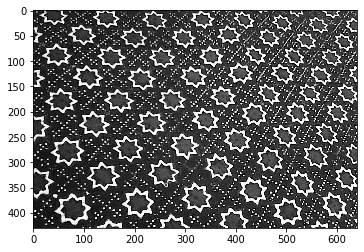

In [24]:
#### Main

#Calculate time elapsed for a model
time_modelling_start = timeit.default_timer()

# Defining paths
root_path = './'
training_folder_path = root_path + 'training/'
validation_folder_path = root_path + 'validation/'
test_folder_path = root_path + 'test/'

# Defining model specifications
img_type = '*.jpg'
sampling_count = 128
k_neighbors = 1
glcm_angle = 0
glcm_distance = 1

# Defining decision tree specifications
minimum_purity = 0.21 #Best minimum purity

# Initializing
initialize_model()
class_names = get_class_names(training_folder_path)
add_classes_to_model(class_names)

# Training
train(training_folder_path, img_type, sampling_count, glcm_angle, glcm_distance)
seed = get_tree_seed(model, minimum_purity)
decision_tree = get_decision_tree(seed, minimum_purity)

# Validating
model_accuracy = validate(validation_folder_path, img_type, decision_tree, minimum_purity)

#Calculate time elapsed for a model
time_modelling_stop = timeit.default_timer()

# Testing
test_img_path = test_folder_path + 'cap2.jpg'
test_img = load_img(test_img_path)
test_img_class = get_img_class(img, decision_tree, minimum_purity)

# Calculate time elapsed for a classification
time_classification_end = timeit.default_timer()

# Print decision tree
print('\n\n')
print_decision_tree(decision_tree)

# Print specifications
print('\n\n')
print('Image processing specifications')
print('===============================')
print('Image type         : ' + img_type)
print('Sampling count     : ' + str(sampling_count))
print('GLCM Angle (deg)   : ' + str(glcm_angle))
print('GLCM distance      : ' + str(glcm_distance))
print()
print('Classification specifications')
print('====================')
print('Classification by  : Decision Tree')
print('Minimum purity     : ' + str(minimum_purity))
print()
print('Model\'s accuracy is around ' + str(model_accuracy) + '%')
print('Time elapsed to make this model is ' + str(time_modelling_stop - time_modelling_start) + ' seconds.')
print()
print('Time elapsed to classify one image is ' + str(time_classification_end - time_modelling_stop) + ' seconds.')
print()
print('This image is categorized as batik ' + test_img_class + '.')
print_img(test_img)

In [10]:
root_path = './'
training_folder_path = root_path + 'training/'
validation_folder_path = root_path + 'validation/'
test_folder_path = root_path + 'test/'

img_type = '*.jpg'

# minimum_purity = 0.30
# maximum_epochs = 10

# seed = get_tree_seed(model, minimum_purity)
# decision_tree = get_decision_tree(seed, minimum_purity, maximum_epochs)

# print(RenderTree(decision_tree))

maximum_epochs = 10
best_minimum_purity = 0
best_accuracy = 0

for k in range(101):
    temp_minimum_purity = k/100
    print('Minimum Purity = ' + str(temp_minimum_purity))
    seed = get_tree_seed(model, temp_minimum_purity)
    decision_tree = get_decision_tree(seed, temp_minimum_purity, maximum_epochs)
    
    temp_accuracy = validate(validation_folder_path, img_type, decision_tree, temp_minimum_purity)
    
    if(temp_accuracy > best_accuracy):
        best_accuracy = temp_accuracy
        best_minimum_purity = temp_minimum_purity

print('Best accuracy       = ' + str(best_accuracy))
print('Best minimum purity = ' + str(best_minimum_purity))


#img = load_img(test_folder_path + 'cap2.jpg')
#img_class = get_img_class(img, decision_tree, minimum_purity)
#print(img_class)

Minimum Purity = 0.0
Accuracy = 0.0%
Minimum Purity = 0.01
Accuracy = 0.0%
Minimum Purity = 0.02
Accuracy = 0.0%
Minimum Purity = 0.03
Accuracy = 0.0%
Minimum Purity = 0.04
Accuracy = 59.375%
Minimum Purity = 0.05
Accuracy = 59.375%
Minimum Purity = 0.06
Accuracy = 59.375%
Minimum Purity = 0.07
Accuracy = 59.375%
Minimum Purity = 0.08
Accuracy = 59.375%
Minimum Purity = 0.09
Accuracy = 59.375%
Minimum Purity = 0.1
Accuracy = 59.375%
Minimum Purity = 0.11
Accuracy = 59.375%
Minimum Purity = 0.12
Accuracy = 61.71875%
Minimum Purity = 0.13
Accuracy = 62.109375%
Minimum Purity = 0.14
Accuracy = 62.109375%
Minimum Purity = 0.15
Accuracy = 64.84375%
Minimum Purity = 0.16
Accuracy = 64.84375%
Minimum Purity = 0.17
Accuracy = 64.84375%
Minimum Purity = 0.18
Accuracy = 64.84375%
Minimum Purity = 0.19
Accuracy = 64.84375%
Minimum Purity = 0.2
Accuracy = 63.671875%
Minimum Purity = 0.21
Accuracy = 71.09375%
Minimum Purity = 0.22
Accuracy = 71.09375%
Minimum Purity = 0.23
Accuracy = 71.09375%
Mini

In [11]:
root_path = './'
training_folder_path = root_path + 'training/'
validation_folder_path = root_path + 'validation/'
test_folder_path = root_path + 'test/'

img_type = '*.jpg'

minimum_purity = 0.21
maximum_epochs = 999

seed = get_tree_seed(model, minimum_purity)
decision_tree = get_decision_tree(seed, minimum_purity, maximum_epochs)

validate

print(RenderTree(decision_tree))

img = load_img(test_folder_path + 'cap2.jpg')
img_class = get_img_class(img, decision_tree, minimum_purity)
print(img_class)

├── <__main__.TreeNode object at 0x000001B4059C3F88>
│   ├── <__main__.TreeNode object at 0x000001B405A3CB08>
│   │   ├── <__main__.TreeNode object at 0x000001B405889308>
│   │   └── <__main__.TreeNode object at 0x000001B4059BE848>
│   │       ├── <__main__.TreeNode object at 0x000001B405A04888>
│   │       │   ├── <__main__.TreeNode object at 0x000001B405914288>
│   │       │   └── <__main__.TreeNode object at 0x000001B405B3B288>
│   │       │       ├── <__main__.TreeNode object at 0x000001B405B3BBC8>
│   │       │       └── <__main__.TreeNode object at 0x000001B405B3B848>
│   │       └── <__main__.TreeNode object at 0x000001B405A04688>
│   └── <__main__.TreeNode object at 0x000001B405AF6E88>
└── <__main__.TreeNode object at 0x000001B4059C3608>
    ├── <__main__.TreeNode object at 0x000001B4059C3908>
    └── <__main__.TreeNode object at 0x000001B4059C3748>
cap


In [ ]:
0.21